
# 🏠 SF Smart Rental Advisor — Data Prep & Baseline Model

מחברת עבודה שלב־שלב: טעינת נתונים → ניקוי → הנדסת מאפיינים → חלוקה ל־Train/Test → אימון מודל בסיסי → שמירת קבצים לממשק Streamlit.

> הקובץ מניח שקובץ הנתונים נמצא בנתיב: `/mnt/data/listings.csv`.  
ניתן לשנות את הנתיב בתא הראשון.


In [1]:

# === Imports ===
import os
import re
import json
import math
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from typing import List, Tuple

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# === Display options ===
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)

# === Paths (edit if needed) ===
DATA_PATH = Path('/mnt/data/listings.csv')   # <- change if your CSV is elsewhere
OUTPUT_DIR = Path('/mnt/data')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CLEAN_CSV = OUTPUT_DIR / 'cleaned_data.csv'
FEATURED_CSV = OUTPUT_DIR / 'featured_data.csv'  # (optional, we rely on pipeline, but keep for inspection)
MODEL_PKL  = OUTPUT_DIR / 'model.pkl'
SCHEMA_JSON = OUTPUT_DIR / 'model_schema.json'   # feature names & basic info for Streamlit


## 1) טעינה והצצה ראשונית לנתונים

In [6]:

# Load CSV
DATA_PATH = Path(r'C:\Users\avivr\Desktop\ai programers\arbnb\listings.csv')
if not DATA_PATH.exists():
    raise FileNotFoundError(f"CSV file not found at {DATA_PATH}. Please check the path and try again.")
df = pd.read_csv(DATA_PATH, low_memory=False)
print(f"Rows: {len(df):,} | Columns: {len(df.columns)}")
df.head(3)


Rows: 7,804 | Columns: 79


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,958.0,https://www.airbnb.com/rooms/958,2.025060e+13,17/06/2025,city scrape,"Bright, Modern Garden Unit - 1BR/1BTH",Our bright garden unit overlooks a lovely back...,Quiet cul de sac in friendly neighborhood<br /...,https://a0.muscache.com/pictures/be1bf5ac-a955...,1169,https://www.airbnb.com/users/show/1169,Holly,31/07/2008,"San Francisco, CA",We are a family of four that live upstairs. W...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/efdad...,https://a0.muscache.com/im/pictures/user/efdad...,Duboce Triangle,1,1,"['email', 'phone']",t,t,Neighborhood highlights,Western Addition,NaN,37.77028,-122.43317,Entire serviced apartment,Entire home/apt,3,1.0,1 bath,1.0,2.0,"[""TEA TREE TRIPLE TREAT\u2122 conditioner"", ""...",$158.00,2,30,2,2,1125,1125,2.0,1125.0,NaN,t,9,11,19,266,17/06/2025,485,40,2,100,50,255,40290.0,23/07/2009,25/05/2025,4.89,4.94,4.93,4.96,4.89,4.97,4.77,STR-0006854,f,1,1,0,0,2.50
1,5858.0,https://www.airbnb.com/rooms/5858,2.025060e+13,17/06/2025,city scrape,Creative Sanctuary,We live in a large Victorian house on a quiet ...,I love how our neighborhood feels quiet but is...,https://a0.muscache.com/pictures/hosting/Hosti...,8904,https://www.airbnb.com/users/show/8904,Philip Jonathon,02/03/2009,"San Francisco, CA",Philip: English transplant to the Bay Area and...,within an hour,100%,88%,f,https://a0.muscache.com/im/users/8904/profile_...,https://a0.muscache.com/im/users/8904/profile_...,Bernal Heights,2,2,"['email', 'phone', 'work_email']",t,t,Neighborhood highlights,Bernal Heights,NaN,37.74474,-122.42089,Entire rental unit,Entire home/apt,4,2.0,2 baths,2.0,2.0,"[""Wifi"", ""Iron"", ""Dryer"", ""Kitchen"", ""Smoke al...",$250.00,30,90,30,30,90,90,30.0,90.0,NaN,t,0,7,37,312,17/06/2025,110,0,0,145,0,0,0.0,03/05/2009,06/08/2017,4.88,4.85,4.87,4.89,4.85,4.77,4.68,NaN,f,1,1,0,0,0.56
2,8014.0,https://www.airbnb.com/rooms/8014,2.025060e+13,17/06/2025,city scrape,female HOST quiet fast internet market parking,Room is on the second floor so it gets a good ...,"The neighborhood is very residential, close to...",https://a0.muscache.com/pictures/2cc1fc3d-0ae0...,22402,https://www.airbnb.com/users/show/22402,Jia,20/06/2009,"San Francisco, CA",Airbnbing while we are doing some renovation a...,within an hour,100%,98%,t,https://a0.muscache.com/im/users/22402/profile...,https://a0.muscache.com/im/users/22402/profile...,Sunnyside,3,8,"['email', 'phone']",t,t,Neighborhood highlights,Outer Mission,NaN,37.73077,-122.44827,Private room in home,Private room,1,2.0,2 shared baths,1.0,1.0,"[""Dryer"", ""Smoking allowed"", ""Self che

In [7]:

# Info & basic describe
print(df.info())
display(df.describe(include='all').transpose().head(25))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7804 entries, 0 to 7803
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7804 non-null   float64
 1   listing_url                                   7804 non-null   object 
 2   scrape_id                                     7804 non-null   float64
 3   last_scraped                                  7804 non-null   object 
 4   source                                        7804 non-null   object 
 5   name                                          7804 non-null   object 
 6   description                                   7705 non-null   object 
 7   neighborhood_overview                         4740 non-null   object 
 8   picture_url                                   7804 non-null   object 
 9   host_id                                       7804 non-null   i

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,7804.0,NaN,NaN,NaN,511645936071859584.0,545373190343860096.0,958.0,26572100.25,54096063.0,1020222500000000000.0,1444540000000000000.0
listing_url,7804,7804,https://www.airbnb.com/rooms/958,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scrape_id,7804.0,NaN,NaN,NaN,20250600000000.0,0.0,20250600000000.0,20250600000000.0,20250600000000.0,20250600000000.0,20250600000000.0
last_scraped,7804,1,17/06/2025,7804,NaN,NaN,NaN,NaN,NaN,NaN,NaN
source,7804,2,city scrape,5813,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,7804,7335,Chic King Suite at Wyndham Donatello in SF,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,7705,6169,This 250 sqft room has a queen bed and a priva...,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood_overview,4740,3245,Russian Hill is a vibrant and desirable neighb...,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
picture_url,7804,7240,https://a0.muscache.com/pictures/miso/Hosting-...,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_id,7804.0,NaN,NaN,NaN,185009596.065479,209803606.828298,1169.0,9576061.25,78910325.0,368819062.0,700306519.0


## 2) פונקציות עזר לזיהוי עמודות וניקוי מחיר

In [8]:

def _find_first(df: pd.DataFrame, candidates: List[str]) -> str:
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    # fuzzy fallback
    for c in df.columns:
        lc = c.lower().replace(' ', '').replace('_','')
        for cand in candidates:
            if cand.lower().replace(' ','').replace('_','') in lc:
                return c
    raise KeyError(f"Could not find any of: {candidates}")

def find_price_col(df: pd.DataFrame) -> str:
    candidates = ['price', 'Price', 'price_per_night', 'listing_price', 'nightly_price']
    return _find_first(df, candidates)

def find_location_col(df: pd.DataFrame) -> str:
    candidates = ['neighbourhood', 'neighborhood', 'neighbourhood_cleansed', 'city', 'district']
    return _find_first(df, candidates)

def find_roomtype_col(df: pd.DataFrame) -> str:
    candidates = ['room_type', 'roomtype', 'room category', 'room', 'listing_room_type']
    return _find_first(df, candidates)

def find_bedrooms_col(df: pd.DataFrame) -> str:
    candidates = ['bedrooms', 'beds', 'num_bedrooms']
    return _find_first(df, candidates)

def find_bathrooms_col(df: pd.DataFrame) -> str:
    candidates = ['bathrooms', 'bathrooms_text', 'num_bathrooms']
    return _find_first(df, candidates)

def to_numeric_price(s: pd.Series) -> pd.Series:
    # remove currency symbols, commas, spaces; keep digits & dot
    cleaned = s.astype(str).str.replace(r'[^0-9\.]+', '', regex=True)
    return pd.to_numeric(cleaned, errors='coerce')


## 3) בחירת עמודות ליבה וניקוי מחיר

In [9]:

# Try to detect core columns
price_col = find_price_col(df)
loc_col = find_location_col(df)
room_col = find_roomtype_col(df)
bed_col = find_bedrooms_col(df)
bath_col = find_bathrooms_col(df)

core_cols = [loc_col, room_col, bed_col, bath_col, price_col]
print("Detected columns:", core_cols)

work = df[core_cols].copy()

# Normalize price to numeric
work['price'] = to_numeric_price(work[price_col])

# Normalize bedrooms/bathrooms to numeric (extract numbers from strings like "1 bath", "1.5 baths")
def _to_num(x):
    if pd.isna(x):
        return np.nan
    # extract first number
    m = re.search(r'(\d+(?:\.\d+)?)', str(x))
    return float(m.group(1)) if m else np.nan

work['bedrooms'] = work[bed_col].apply(_to_num)
work['bathrooms'] = work[bath_col].apply(_to_num)

# Rename categorical
work['neighbourhood'] = work[loc_col].astype(str).str.strip()
work['room_type'] = work[room_col].astype(str).str.strip()

# Reorder columns
work = work[['neighbourhood', 'room_type', 'bedrooms', 'bathrooms', 'price']]

work.head(10)


Detected columns: ['neighbourhood', 'room_type', 'bedrooms', 'bathrooms', 'price']


,neighbourhood,room_type,bedrooms,bathrooms,price
0,Neighborhood highlights,Entire home/apt,1.0,1.0,158.0
1,Neighborhood highlights,Entire home/apt,2.0,2.0,250.0
2,Neighborhood highlights,Private room,1.0,2.0,62.0
3,Neighborhood highlights,Private room,3.0,4.0,55.0
4,nan,Entire home/apt,1.0,1.5,527.0
5,nan,Private room,1.0,1.5,107.0
6,Neighborhood highlights,Entire home/apt,0.0,1.0,100.0
7,Neighborhood highlights,Private room,1.0,1.0,70.0
8,Neighborhood highlights,Private room,1.0,3.0,65.0
9,Neighborhood highlights,Private room,1.0,3.0,65.0


## 4) טיפול בחסרים וסינון קיצונים במחיר

In [10]:

# Drop rows with missing critical fields
critical = ['neighbourhood', 'room_type', 'price']
before = len(work)
work = work.dropna(subset=critical)
print(f"Dropped due to missing in {critical}: {before - len(work):,} rows")

# Filter outliers by price (40$–1000$) — adjust if needed
min_price, max_price = 40, 1000
before = len(work)
work = work[(work['price'] >= min_price) & (work['price'] <= max_price)]
print(f"Filtered by price [{min_price}, {max_price}]: {before - len(work):,} rows removed")

# Fill secondary numeric NaNs with median
for col in ['bedrooms', 'bathrooms']:
    if col in work.columns:
        med = work[col].median(skipna=True)
        work[col] = work[col].fillna(med)

print(work.isna().sum())
work.head(5)


Dropped due to missing in ['neighbourhood', 'room_type', 'price']: 2,039 rows
Filtered by price [40, 1000]: 196 rows removed
neighbourhood    0
room_type        0
bedrooms         0
bathrooms        0
price            0
dtype: int64


,neighbourhood,room_type,bedrooms,bathrooms,price
0,Neighborhood highlights,Entire home/apt,1.0,1.0,158.0
1,Neighborhood highlights,Entire home/apt,2.0,2.0,250.0
2,Neighborhood highlights,Private room,1.0,2.0,62.0
3,Neighborhood highlights,Private room,3.0,4.0,55.0
4,nan,Entire home/apt,1.0,1.5,527.0


## 5) ויזואליזציה מהירה (לא חובה)

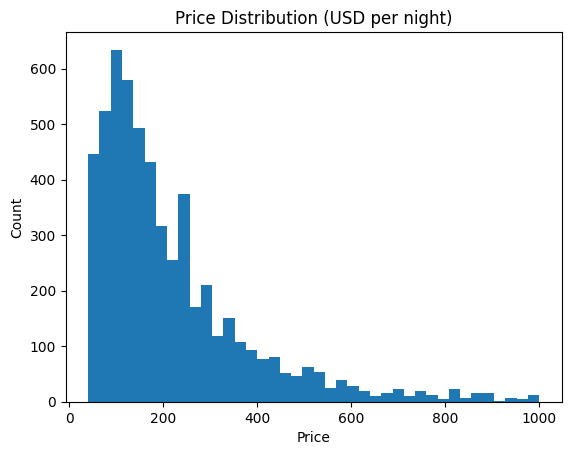

In [11]:

# Histogram of price
plt.figure()
work['price'].plot(kind='hist', bins=40, title='Price Distribution (USD per night)')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


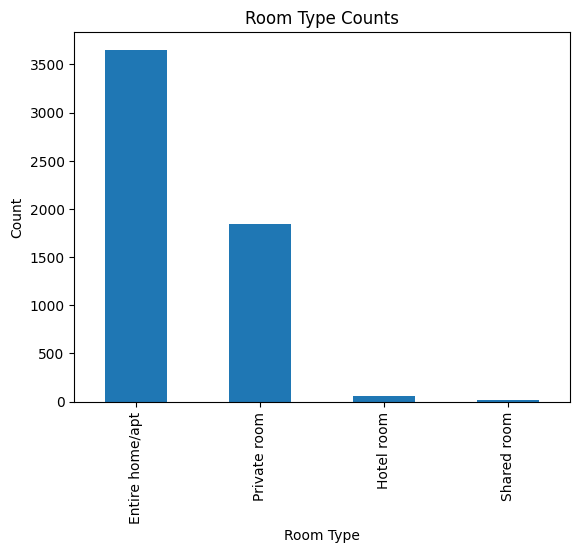

In [12]:

# Room type counts (if exists)
if 'room_type' in work.columns:
    plt.figure()
    work['room_type'].value_counts().sort_values(ascending=False).plot(kind='bar', title='Room Type Counts')
    plt.xlabel('Room Type')
    plt.ylabel('Count')
    plt.show()


## 6) שמירת נתונים נקיים

In [13]:

work.to_csv(CLEAN_CSV, index=False)
print('Saved:', CLEAN_CSV)


Saved: \mnt\data\cleaned_data.csv


## 7) (אופציונלי) יצירת featured_data.csv לבדיקה ידנית

In [14]:

# A quick one-hot encoding for inspection only (training uses a Pipeline)
featured = work.copy()
cat_cols = ['neighbourhood', 'room_type']
for c in cat_cols:
    if c in featured.columns:
        dummies = pd.get_dummies(featured[c], prefix=c, dummy_na=False)
        featured = pd.concat([featured.drop(columns=[c]), dummies], axis=1)

featured.to_csv(FEATURED_CSV, index=False)
print('Saved:', FEATURED_CSV, '| shape:', featured.shape)


Saved: \mnt\data\featured_data.csv | shape: (5569, 9)


## 8) חלוקה ל־Train/Test, מודל בסיסי (RandomForest) וצנרת עיבוד

In [15]:

# Features & target
target = 'price'
X = work.drop(columns=[target])
y = work[target].astype(float)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

# Identify columns by type
categorical_features = [c for c in X.columns if X[c].dtype == 'object']
numeric_features = [c for c in X.columns if c not in categorical_features]

# Preprocess: OneHot for categorical, passthrough numeric
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', 'passthrough', numeric_features),
    ]
)

# Model
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

# Pipeline
pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', model)
])

# Train
pipe.fit(X_train, y_train)

# Evaluate
preds = pipe.predict(X_test)
mae = mean_absolute_error(y_test, preds)
r2  = r2_score(y_test, preds)
print(f"MAE: {mae:,.2f} USD | R²: {r2:0.3f}")


MAE: 85.39 USD | R²: 0.407


## 9) שמירת המודל והסכמה לשימוש ב־Streamlit

In [16]:

# Save pipeline
joblib.dump(pipe, MODEL_PKL)
print('Saved model:', MODEL_PKL)

# Save schema (columns for Streamlit form hints)
schema = {
    "categorical_features": categorical_features,
    "numeric_features": numeric_features,
    "target": target
}
with open(SCHEMA_JSON, 'w', encoding='utf-8') as f:
    json.dump(schema, f, ensure_ascii=False, indent=2)
print('Saved schema:', SCHEMA_JSON)


Saved model: \mnt\data\model.pkl
Saved schema: \mnt\data\model_schema.json


## 10) בדיקת חיזוי לדוגמה (Sanity Check)

In [17]:

# Take a median sample & predict
sample = X_test.iloc[[0]].copy() if len(X_test) else X.iloc[[0]].copy()
print('Sample input:')
display(sample)

pred_price = pipe.predict(sample)[0]
print(f'Predicted nightly price: {pred_price:,.2f} USD')


Sample input:


,neighbourhood,room_type,bedrooms,bathrooms
1532,Neighborhood highlights,Entire home/apt,1.0,1.0


Predicted nightly price: 216.64 USD
